In [1]:
%load_ext jupyter_black

## Load Packages <a class="anchor" id="load_packages"></a>

Packages relavant to th code are loaded below. Additionally, specific options or parameters are also set. For example, display options are set for `pandas` and the environment path to the environment variable file is provided for the `dotenv` package.

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import os
import sys
import pandas as pd
import numpy as np
import requests
from spotify_dl import spotify_dl
from pathlib import Path
import time
import os
from dotenv import load_dotenv  # changed magic command to explicit load
import librosa
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import pairwise
from sklearn.model_selection import train_test_split
from typing import List
from flask import Flask, redirect, request

pd.set_option("display.max_rows", None)  # pandas dataframe formatting options
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.2f}".format


custom_env_path = "../../brainstation_capstone_cfg.env"  # environment variables file

## Setting Environment Variables <a class="anchor" id="set_env_vars"></a>

In [3]:
# Spotify Developer Credentials
load_dotenv(dotenv_path=custom_env_path)
CLIENT_ID = os.environ.get("SPOTIPY_CLIENT_ID")
# client ID from app
CLIENT_SECRET = os.environ.get("SPOTIPY_CLIENT_SECRET")
# client secret from app
REDIRECT_URI = os.environ.get("REDIRECT_URI")
# redirect URI - the URI used here matches the one used within the app
SCOPE = "{} {}".format(os.environ.get("SCOPE_PUBLIC"), os.environ.get("SCOPE_PRIVATE"))
# formatted the scope this way to allow for custom configurations in the future
USERNAME = os.environ.get("SPOTIFY_USERNAME")
# Spotify username

[Back to Table of Contents](#toc)

In [22]:
# How was this solved? sampling rate must be explicitly passed to every function
# This includes the display function itself!
# Hence, the sampling rate is now an output from the function itself
def get_mfcc(y, sr):
    mfcc = librosa.power_to_db(librosa.feature.mfcc(y=y, sr=sr), ref=np.max)
    return mfcc


def get_melspectrogram(y, sr):
    melspectrogram = librosa.power_to_db(
        librosa.feature.melspectrogram(y=y, sr=sr), ref=np.max
    )
    # this is a power spectrum (amplitude squared)
    return melspectrogram


def get_chroma_vector(y, sr):
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    return chroma


def get_tonnetz(y, sr):
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr)
    return tonnetz


def get_feature(file_path):
    # Load data
    y, sr = librosa.load(
        file_path,
        sr=None,
        offset=10,
        duration=120,
    )
    # Extracting MFCC feature
    mfcc = get_mfcc(y, sr)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_min = mfcc.min(axis=1)
    mfcc_max = mfcc.max(axis=1)
    mfcc_feature = np.concatenate((mfcc_mean, mfcc_min, mfcc_max))

    # Extracting Mel Spectrogram feature
    melspectrogram = get_melspectrogram(y, sr)
    melspectrogram_mean = melspectrogram.mean(axis=1)
    melspectrogram_min = melspectrogram.min(axis=1)
    melspectrogram_max = melspectrogram.max(axis=1)
    melspectrogram_feature = np.concatenate(
        (melspectrogram_mean, melspectrogram_min, melspectrogram_max)
    )

    # Extracting chroma vector feature
    chroma = get_chroma_vector(y, sr)
    chroma_mean = chroma.mean(axis=1)
    chroma_min = chroma.min(axis=1)
    chroma_max = chroma.max(axis=1)
    chroma_feature = np.concatenate((chroma_mean, chroma_min, chroma_max))

    # Extracting tonnetz feature
    tntz = get_tonnetz(y, sr)
    tntz_mean = tntz.mean(axis=1)
    tntz_min = tntz.min(axis=1)
    tntz_max = tntz.max(axis=1)
    tntz_feature = np.concatenate((tntz_mean, tntz_min, tntz_max))

    feature = np.concatenate(
        (chroma_feature, melspectrogram_feature, mfcc_feature, tntz_feature)
    )
    return feature


# May not have use of this function yet....need to fix pairwise comparison
# Save spectra one stage before as separate vectors BEFORE concatenation
def create_spectra(spec_data, sr, type, track_id):
    if type == "mfcc":
        plt.figure()
        librosa.display.specshow(mel_data, y_axis="mel", x_axis="time", sr=sr)
        plt.title("Mel Frequency Cepstral Coefficients")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
    if type == "melspectrogram":
        plt.figure()
        librosa.display.specshow(mel_data, y_axis="mel", x_axis="time", sr=sr)
        plt.title("Melspectrogram")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
    if type == "chroma":
        plt.figure()
        librosa.display.specshow(
            mel_data, y_axis="chroma", x_axis="time", sr=sr, vmin=0, vmax=1
        )
        plt.title("Chroma STFT")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
    if type == "tonnetz":
        plt.figure()
        librosa.display.specshow(
            mel_data, y_axis="tonnetz", x_axis="time", sr=sr, vmin=0, vmax=1
        )
        plt.title("Tonnetz")
        plt.colorbar(format="%+2.0f dB")
        plt.savefig(f"../data/mp3_spectra/{track_id}.png", bbox_inches="tight")
        # Will have to get the track_id to save the file
        # Not sure if the spectra must have the axis labels or the title

In [23]:
example_file = "/Users/vii/repos/brainstation_capstone/data/mp3s/1ZB2qWsheGabSEYvBYxjKn/Take on Me/Weezer - Take on Me.mp3"

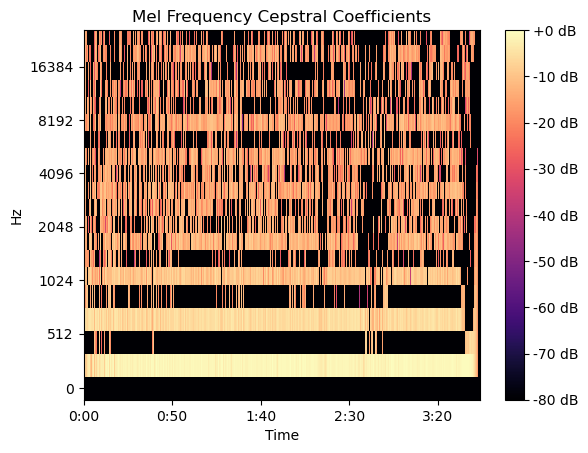

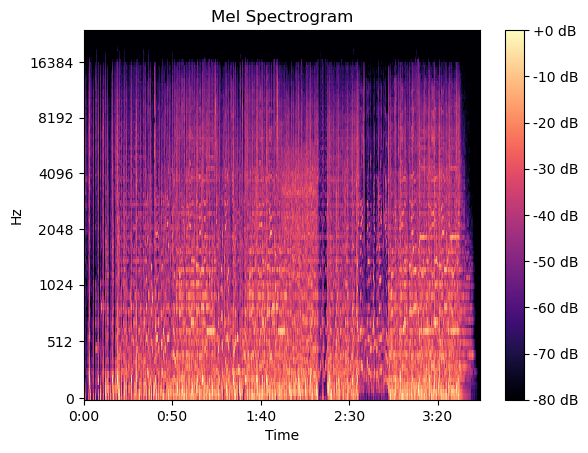

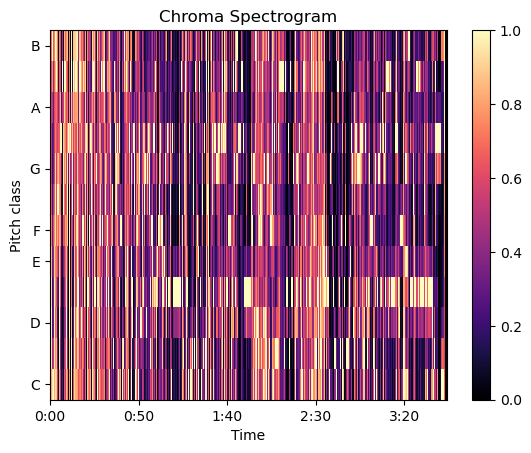

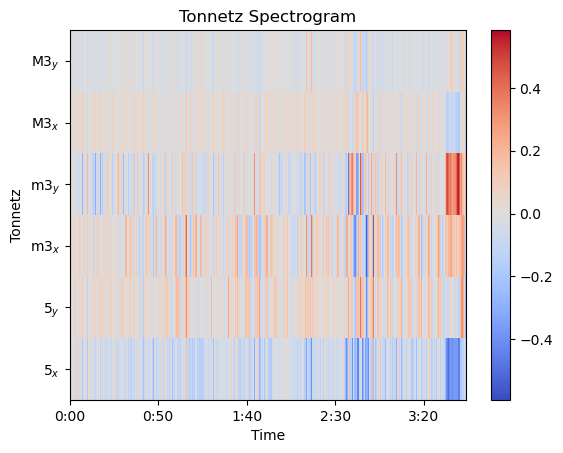

In [29]:
y, sr = librosa.load(
    example_file,
    sr=None,
    # offset=10,
    # duration=180,
)
mfcc = get_mfcc(y, sr)
# power_to_db takes in np.array
plt.figure()
librosa.display.specshow(mfcc, y_axis="mel", x_axis="time", sr=sr)
plt.title("Mel Frequency Cepstral Coefficients")
plt.colorbar(format="%+2.0f dB")
plt.show()
melspectrogram = get_melspectrogram(y, sr)
# power_to_db takes in np.array
plt.figure()
librosa.display.specshow(melspectrogram, y_axis="mel", x_axis="time", sr=sr)
plt.title("Mel Spectrogram")
plt.colorbar(format="%+2.0f dB")
plt.show()
plt.figure()
chroma = get_chroma_vector(y, sr)
librosa.display.specshow(
    chroma,
    y_axis="chroma",
    x_axis="time",
    sr=sr,
)  # vmin=0, vmax=1)
plt.title("Chroma Spectrogram")
plt.colorbar()
plt.show()
tonnetz = get_tonnetz(y, sr)
librosa.display.specshow(
    tonnetz,
    y_axis="tonnetz",
    x_axis="time",
    sr=sr,  # vmin=0, vmax=1
)
plt.title("Tonnetz Spectrogram")
plt.colorbar()
plt.show()